In [1]:
import numpy as np
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model,Sequential
import pandas as pd
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve
from sklearn import metrics
import matplotlib.pyplot as plt
import itertools
from tqdm import tqdm
import scikitplot as skplt

In [2]:
def normalize(df_orig):
    x = df_orig.values 
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df_normalized = pd.DataFrame(x_scaled, columns = df_orig.columns, index= df_orig.index)
    return df_normalized


def data_preparation(df):
    proto = pd.get_dummies(df['proto'])
    land = df['sport'] == df['dport']
    land[land == True] = 1
    land[land == False] = 0
    category = df.pop('category')
    subcategory = df.pop('subcategory')
    attack = df.pop('attack')
    category = pd.get_dummies(category)
    df[proto.columns] = proto
    df['land'] = land
    state = pd.get_dummies(df['state'])
    df[state.columns] = state
    
    del(df['pkSeqID'])
    del(df['seq'])
    del(df['stime'])
    del(df['flgs'])
    del(df['smac'])
    del(df['dmac'])
    del(df['soui'])
    del(df['doui'])
    del(df['sco'])
    del(df['dco'])
    del(df['proto'])
    del(df['saddr'])
    del(df['daddr'])
    del(df['dport'])
    del(df['sport'])
    del(df['state'])
    
    df = normalize(df)
    df = df.astype(np.float32)
    return df, category

In [3]:
file_path = r'C:\Users\Евгений\Desktop\finaldatasets.csv'
df = pd.read_csv(file_path)

In [4]:
df, category = data_preparation(df)
df.head()

,pkts,bytes,ltime,dur,mean,stddev,sum,min,max,spkts,...,tcp,udp,land,CON,FIN,INT,NRS,REQ,RST,URP
0,0.000028,1.784838e-06,0.574316,1.049121e-02,0.000019,0.000053,7.936079e-08,0.000000,0.000056,0.000021,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.000003,5.127442e-08,0.183705,7.013396e-08,0.000050,0.000000,7.079667e-08,0.000050,0.000050,0.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000022,2.749286e-06,0.574249,5.319137e-03,0.004040,0.008054,1.153072e-05,0.000023,0.008056,0.000017,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.000022,2.350078e-06,0.574262,5.477234e-03,0.003188,0.006226,9.099085e-06,0.000082,0.006293,0.000017,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.000000,1.220820e-08,0.000140,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [5]:
train_df, test_df = np.split(df, [int(.8*len(df))])
train_category = category.head(len(train_df))
test_category = category.loc[len(train_df):]

In [6]:
model = keras.Sequential([
    Dense(31, activation='relu'),
    Dense(60, activation='relu'),
    Dense(4, activation='softmax')
])

myAdam = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=myAdam, loss='categorical_crossentropy', metrics=['accuracy'])

In [7]:
history = model.fit(train_df, train_category, epochs=10)

Epoch 1/10
633/633 [==============================] - 1s 2ms/step - loss: 0.3289 - accuracy: 0.8938
Epoch 2/10
633/633 [==============================] - 1s 1ms/step - loss: 0.0715 - accuracy: 0.9788
Epoch 3/10
633/633 [==============================] - 1s 1ms/step - loss: 0.0636 - accuracy: 0.9792
Epoch 4/10
633/633 [==============================] - 1s 2ms/step - loss: 0.0611 - accuracy: 0.9798
Epoch 5/10
633/633 [==============================] - 1s 1ms/step - loss: 0.0603 - accuracy: 0.9798
Epoch 6/10
633/633 [==============================] - 1s 2ms/step - loss: 0.0596 - accuracy: 0.9799
Epoch 7/10
633/633 [==============================] - 1s 2ms/step - loss: 0.0597 - accuracy: 0.9799
Epoch 8/10
633/633 [==============================] - 1s 2ms/step - loss: 0.0588 - accuracy: 0.9801
Epoch 9/10
633/633 [==============================] - 1s 1ms/step - loss: 0.0592 - accuracy: 0.9802
Epoch 10/10
633/633 [==============================] - 1s 1ms/step - loss: 0.0588 - accuracy: 0.9804

In [8]:
model.evaluate(test_df, test_category)

159/159 [==============================] - 0s 878us/step - loss: 0.0606 - accuracy: 0.9771


[0.060551490634679794, 0.9770932197570801]

In [19]:
def print_stats(y_predicted_counts_proba_, y_test_, atk_norm=False, classes_=['positive', 'Negative']):
    y_test_ = np.argmax(y_test_.values, axis=1)
    if atk_norm:
        y_predicted_counts_proba, y_test, = merge(y_predicted_counts_proba_, y_test_)
    else:
        y_predicted_counts_proba, y_test = y_predicted_counts_proba_, y_test_
    
    y_predicted_counts = np.array(y_predicted_counts_proba).argmax(axis=-1)
    keys, vals = define_metrics(y_test, y_predicted_counts, y_predicted_counts_proba)
    stats = pd.DataFrame([[round(x, 3) if not type(x) == str else x for x in vals]], columns=keys, index=['    '])
    display(stats)
    
    fig_scale = 0.6 if atk_norm else 0.9
    # В одной строке разместим 2 графика (график, табл)
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=[int(fig_scale * x) for x in (16, 7)])
    # ROC
    _ = skplt.metrics.plot_roc(y_test, y_predicted_counts_proba, figsize=(int(14*0.7), int(10*0.7)), plot_micro=False, plot_macro=False, ax=axs)
    _ = plot_confusion_matrix(y_test_, np.argmax(y_predicted_counts_proba_, axis=1), classes = classes_, normalize=False)
    plt.show()

,Accuracy,Precision,Recall,F-score,MСС,ROC AUC,Log Loss
,0.977,0.978,0.977,0.977,0.968,1.0,0.061


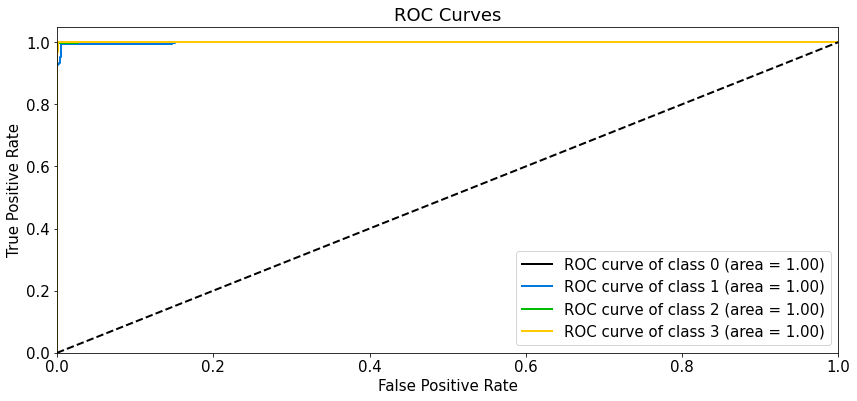

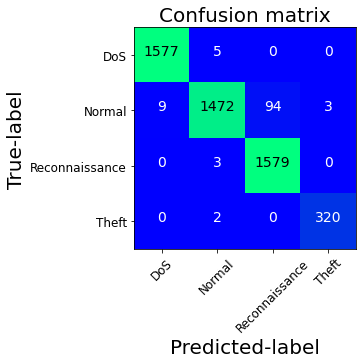

In [20]:
print_stats(model.predict(test_df), test_category, classes_ = test_category.columns)

In [18]:
def roc_calc(model, testX, testy):
    ns_probs = [0 for _ in range(len(testy))]
    lr_probs = model.predict_proba(testX)
    lr_probs = lr_probs[:]
    ns_auc = roc_auc_score(testy, ns_probs)
    lr_auc = roc_auc_score(testy, lr_probs)
    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print('Logistic: ROC AUC=%.3f' % (lr_auc))
    ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs)
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()
    
    
def define_metrics(y_test, y_predicted, y_predicted_proba):  
    # точность(precision)
    precision = metrics.precision_score(y_test, y_predicted, pos_label=None, average='weighted')             
    # Полнота (recall)
    recall = metrics.recall_score(y_test, y_predicted, pos_label=None, average='weighted') 
    # F-мера - среднее точности и полноты
    f1 = metrics.f1_score(y_test, y_predicted, pos_label=None, average='weighted')    
    # Accuracy – доля правильных ответов алгоритма
    accuracy = metrics.accuracy_score(y_test, y_predicted)
    #Коэффициент корреляции Мэтьюза: +1 представляет идеальное предсказание, 
    # 0 - среднее случайное предсказание и -1 - обратное предсказание. 
    matthews_corrcoef = metrics.matthews_corrcoef(y_test, y_predicted)
    try:
        #Вычислить площадь под кривой рабочих характеристик приемника (ROC AUC) по оценкам прогнозов.
        roc_auc_ovr = metrics.roc_auc_score(y_test, y_predicted_proba, average='weighted', multi_class='ovr')
    except ValueError:
        roc_auc_ovr = '-'
    
    try:
        #Функция правдоподобия отвечает на вопрос:«Насколько вероятным, по мнению модели,
        #  был фактически наблюдаемый набор результатов»
        log_loss = metrics.log_loss(y_test, y_predicted_proba)
    except ValueError:
        log_loss = '-'
    
    return ['Accuracy', 'Precision', 'Recall', 'F-score', 'MСС', 'ROC AUC', 'Log Loss'], \
           [accuracy,    precision,   recall,   f1,    matthews_corrcoef,    roc_auc_ovr, log_loss]


def merge(y_predicted_proba, y_test):
    norm_ind = list(label_encoder.transform(['Normal']))[0]
    y_test_2 = [0 if x == norm_ind else 1 for x in y_test]
    y_predicted_counts_2 = [[x[norm_ind], sum(x) - x[norm_ind]] for x in y_predicted_proba]
    return y_predicted_counts_2, y_test_2




def plot_confusion_matrix(Y, X, normalize=True,classes=['Positive', 'Negative'], cmap=plt.cm.winter):
    cm = confusion_matrix(Y, X)
    plt.figure(figsize=(7, 5))
    font = {'size' : 15}
    plt.rc('font', **font)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if np.isnan(cm[i, j]):
            cm[i, j] = 0.0
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix', fontsize=20)
    # plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=12, rotation=45)
    plt.yticks(tick_marks, classes, fontsize=12)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=14)
    
    plt.tight_layout()
    plt.ylabel('True-label', fontsize=20)
    plt.xlabel('Predicted-label', fontsize=20)

    return plt